[init] Using pH0 = 7.310 at T = 40.0 °C → Kw=2.88e-14, pKw=13.54
       strong-ion net (Na+ - Cl-) = 0.0000 M
[fit] Optimizing parameters ...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8536e+00                                    1.69e-01    
       1              2         1.8231e+00      3.06e-02       7.75e+00       3.32e-01    
[warn] simulation failure at a=1.0, kd=0.0, ts=22.20335695588703, tau=0.0, kLa=0.0: Values in `t_eval` are not properly sorted.
[warn] simulation failure at a=1.0, kd=0.0, ts=11.360314258282884, tau=0.0, kLa=0.0: Values in `t_eval` are not properly sorted.
       2              5         1.8166e+00      6.49e-03       9.04e-01       4.23e-01    
[warn] simulation failure at a=1.0, kd=0.0, ts=10.441034228769585, tau=0.0, kLa=0.0: Values in `t_eval` are not properly sorted.
       3              7         1.8126e+00      4.01e-03       4.48e-01       4.95e-01    
       4         

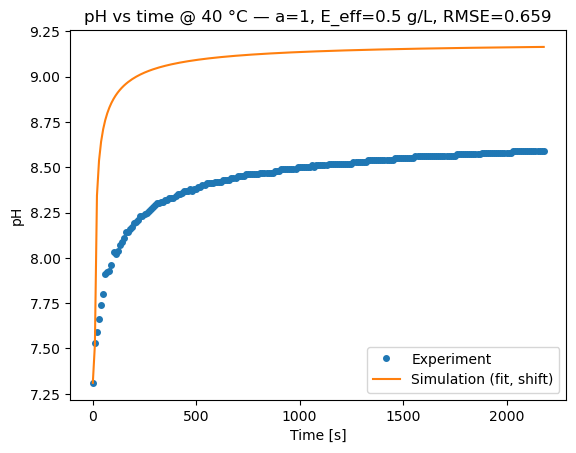

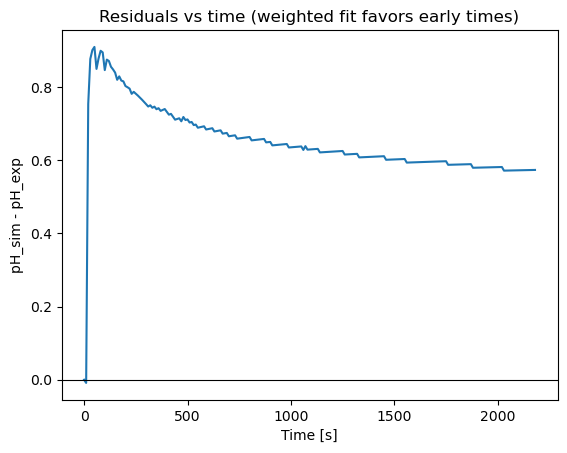

In [6]:
# Fit urease activity to experimental pH(t) using the "new" simulator
# — now fully temperature-aware:
#   • pH-activity parameters switch/interpolate with T (25↔40 °C table)
#   • water autoprotolysis Kw uses pKw(T)
#   • kinetics Arrhenius already uses T
#
# Optional knobs:
#   - first-order enzyme deactivation (k_deact)
#   - small time shift (t_shift) and probe first-order lag (tau_probe)
#   - optional NH3 stripping (fit or fixed), CO2 kept closed by default
#
# Outputs a timestamped folder with: overlay plot, residual plot,
# fitted pH series, and a species/conversion CSV (optionally extended
# until near-full conversion).

import os, sys, math, json, re
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, least_squares

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# --- Experimental data ---
exp_csv_path =  "/Users/hosseinostovar/Desktop/BACKUP/Data_Urease/urease=0,087gr_urea=20mM_T=40C/pH/3rd_20mM_Urea_0,87g_Urease.csv"   # <-- set this path
time_to_seconds = 1.0           # 1.0 if CSV time is seconds; 60.0 if minutes→seconds
TIME_COL_HINTS = ["time", "t", "sec", "s)"]  # detection hints
PH_COL_HINTS   = ["ph"]                           # detection hints

# --- Reactor & enzyme (mass-based) ---
volume_L               = 0.2
grams_urease_powder    = 0.10
powder_activity_frac   = 1.0   # MASS purity (0–1)
E_loading_base_g_per_L = grams_urease_powder * powder_activity_frac / volume_L  # g/L
# We'll fit an "activity_scale" that multiplies this mass loading.

# --- Chemistry (no CO2 steering) ---
S0         = 0.020   # urea [M]
N0         = 0.0     # total ammonia [M]
C0         = 0.0     # total inorganic carbon [M]
Pt_total_M = 0.0     # phosphate [M]; keep 0 to disable inhibition

# --- Temperature (isothermal) ---
T_isothermal_K = 313.15  # 40 °C  ← change this and the model adjusts pH-activity & Kw automatically

# --- Fitting switches (turn on the effects you want the optimizer to include) ---
fit_activity  = False      # scale factor multiplying E_loading_base_g_per_L
fit_k_deact   = False      # first-order enzyme deactivation (s^-1)
fit_t_shift   = True      # small time shift (s): model evaluated at t = t_exp - t_shift
fit_tau_probe = False     # 1st-order probe lag (s)
# NH3 volatilization (open beaker effect). CO2 kept closed by default.
strip_NH3        = False   # if True, include NH3 loss with kLa_NH3_s (fixed or fitted)
fit_kLa_NH3      = False   # fit kLa_NH3_s if True; else use kLa_NH3_s_fixed
kLa_NH3_s_fixed  = 0.0     # 1/s; used if strip_NH3=True and fit_kLa_NH3=False

# --- Bounds & initial guesses ---
activity_bounds = (1e-4, 100.0)   # multiplies mass loading
k_deact_bounds  = (0.0, 5e-3)     # s^-1
t_shift_bounds  = (-10.0, 60.0)   # s
tau_bounds      = (0.0, 60.0)     # s
kLa_bounds      = (0.0, 5e-2)     # s^-1

activity_initial_guess = 1.0
k_deact_initial_guess  = 0.0
t_shift_initial_guess  = 0.0
tau_initial_guess      = 0.0
kLa_initial_guess      = 0.003    # if fit_kLa_NH3=True

# --- Early-time weighting (emphasize initial slope & "elbow") ---
t_weight      = 400.0   # seconds where weight ~1/2
weight_power  = 2.0     # larger → more emphasis on early data

# --- Optimizer robustness ---
robust_loss   = 'soft_l1'  # 'linear' for plain least squares
f_scale_ph    = 0.03       # robust scale in pH units

# --- Output folder (auto) ---
exp_tag = Path(exp_csv_path).stem or "data"
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = Path(f"fit_out_{exp_tag}_{ts}")
out_dir.mkdir(parents=True, exist_ok=True)

# --- Species timeseries extension controls ---
species_to_full_conversion   = True     # if True, integrate species until depletion (or timeout)
species_urea_cut_frac        = 1e-6     # define "depleted": S < cut_frac*S0
species_tmax_if_no_conv_s    = 24*3600  # safety cap if deactivation prevents full conversion

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & TEMPERATURE LOGIC               ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics (Qin & Cabral, per gram of enzyme powder)
k0_mol_per_s_per_g = 0.267   # mol NH3/(s·g), frequency factor
Ea    = 29.1e3               # J/mol
KM, Ks = 2.56e-3, 6.18       # M

# pH-activity parameters as a function of T (linear interpolation 25↔40 °C, clamped)
# tuples: (T[K], pKa_es1, pKa_es2, alpha_e, beta_e)
_PH_ACT_TABLE = [
    (298.15, 9.07, 5.62, 0.373, 0.564),  # 25 °C
    (313.15, 9.58, 5.15, 0.542, 0.769),  # 40 °C
]
def _lin_interp(x, x0, x1, y0, y1):
    if x <= x0: return y0
    if x >= x1: return y1
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

def pH_activity_params(TK):
    (T0,a0,b0,c0,d0),(T1,a1,b1,c1,d1) = _PH_ACT_TABLE
    return (_lin_interp(TK,T0,T1,a0,a1),
            _lin_interp(TK,T0,T1,b0,b1),
            _lin_interp(TK,T0,T1,c0,c1),
            _lin_interp(TK,T0,T1,d0,d1))

# Product inhibition Kp(pH) is ~independent of T up to 40 °C in the data
_KP_POINTS = [
    (6.25, 0.1785), (6.50, 0.1194), (7.00, 0.0693), (7.50, 0.0386),
    (8.00, 0.0311), (8.50, 0.0327), (8.75, 0.0298), (9.00, 0.0310),
]
def Kp_of_pH(pH):
    pts = _KP_POINTS
    if pH <= pts[0][0]: return pts[0][1]
    if pH >= pts[-1][0]: return pts[-1][1]
    for (pa,Ka),(pb,Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w*(Kb - Ka)
    return pts[-1][1]

# Temperature-dependent water autoprotolysis pKw(T) (simple table 25↔40 °C; extend if needed)
_PKW_TABLE = [
    (298.15, 14.00),  # 25 °C
    (313.15, 13.54),  # 40 °C
]
def pKw_of_T(TK):
    (T0,K0),(T1,K1) = _PKW_TABLE
    return _lin_interp(TK,T0,T1,K0,K1)
def Kw_of_T(TK): return 10.0**(-pKw_of_T(TK))

# Acid–base constants (kept fixed; if you want full T-dependence, add van't Hoff here)
Ka_NH4 = 5.62e-10
Ka1    = 4.45e-7
Ka2    = 4.69e-11
Ka1p   = 7.11e-3
Ka2p   = 6.32e-8
Ka3p   = 4.22e-13

# Global Kw (set once for this isothermal run), and strong-ion background
Kw = Kw_of_T(T_isothermal_K)
B_STRONG = 0.0
_SPEC_LAST_LOGH = {"val": 7.0}  # warm start

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH (charge balance)                ║
# ╚══════════════════════════════════════════════════════════════╝

def _charge_balance(logH, Ntot, Ctot, Ptot):
    H  = 10**(-logH)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot):
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)
    lo = max(1.0, _SPEC_LAST_LOGH["val"] - 3.0)
    hi = min(13.0, _SPEC_LAST_LOGH["val"] + 3.0)
    f_lo = _charge_balance(lo, Ntot, Ctot, Ptot)
    f_hi = _charge_balance(hi, Ntot, Ctot, Ptot)
    if f_lo * f_hi > 0: lo, hi = 1.0, 13.0
    sol = root_scalar(_charge_balance, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot))
    logH = sol.root
    _SPEC_LAST_LOGH["val"] = logH
    H  = 10**(-logH); OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4)); NH3 = Ntot - NH4
    denom_c = H*H + Ka1*H + Ka1*Ka2
    CO2  = Ctot * (H*H / denom_c)
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return {'pH': -math.log10(H), 'H': H, 'OH': OH,
            'NH3': NH3, 'NH4': NH4,
            'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
            'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4}

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot):
    H  = 10**(-pH_target)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    # B = RHS - LHS (without Na/Cl)
    return (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) - (H + NH4)

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """NH3 formation rate per gram of urease [mol/(g·s)], T-aware."""
    S = max(S, 0.0)
    # Arrhenius
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))
    # pH activity (temperature-specific)
    pKa1, pKa2, alpha_e, beta_e = pH_activity_params(T)
    Kes1, Kes2 = 10**(-pKa1), 10**(-pKa2)
    H = 10**(-pH)
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)
    # competitive phosphate (inactive if Pt_total_M=0)
    alpha_comp = 1.0 + (P_inhib / 0.010 if (Pt_total_M > 0.0) else 0.0)
    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)
    # noncompetitive product inhibition (total ammonia with pH-dependent Kp)
    return v_sub / (1.0 + max(Ntot,0.0) / Kp_of_pH(pH))

def make_rhs_isothermal(E0_g_per_L, k_deact_per_s=0.0,
                        use_strip_NH3=False, kLa_NH3_s=0.0):
    """Build RHS(t,y) with optional 1st-order deactivation and NH3 stripping."""
    def rhs(t, y):
        S, Ntot, Ctot = y
        sp  = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH  = sp['pH']
        P_inhib = (sp['H2PO4'] + sp['HPO4']) if Pt_total_M > 0 else 0.0
        per_g = rate_per_g(S, Ntot, pH, T_isothermal_K, P_inhib)
        # active enzyme (g/L)
        E_active = E0_g_per_L * math.exp(-max(k_deact_per_s,0.0) * max(t,0.0))
        r_NH3 = per_g * E_active                     # mol/L/s produced
        # gas loss (mol/L/s)
        r_strp_NH3 = (kLa_NH3_s * sp['NH3']) if use_strip_NH3 else 0.0
        dS_dt = -0.5 * r_NH3
        dN_dt =        r_NH3 - r_strp_NH3
        dC_dt =  0.5 * r_NH3
        return [dS_dt, dN_dt, dC_dt]
    return rhs

# ╔══════════════════════════════════════════════════════════════╗
# ║                LOAD EXP DATA & INITIALIZE B_STRONG           ║
# ╚══════════════════════════════════════════════════════════════╝

def _detect_col(df, hints):
    # robust-ish search for a column containing any hint
    for h in hints:
        h_low = h.lower()
        for c in df.columns:
            name = str(c).lower()
            if h_low in name:
                return c
    # fallbacks: try exact pH or "t(s)" tokens
    for c in df.columns:
        name = str(c).lower().replace(" ", "")
        if name in {"ph", "pH"}:
            return c
    for c in df.columns:
        if re.search(r"t\s*\(\s*s\s*\)", str(c).lower()):
            return c
    return None

# read CSV with sniffing
exp_df = pd.read_csv(exp_csv_path)
time_col = _detect_col(exp_df, TIME_COL_HINTS)
ph_col   = _detect_col(exp_df, PH_COL_HINTS)
if time_col is None or ph_col is None:
    raise ValueError(f"Could not detect time/pH columns in {exp_csv_path}. Columns: {list(exp_df.columns)}")

exp_times = np.asarray(exp_df[time_col], dtype=float) * float(time_to_seconds)
exp_pH    = np.asarray(exp_df[ph_col], dtype=float)
mask = np.isfinite(exp_times) & np.isfinite(exp_pH)
exp_times = exp_times[mask]
exp_pH    = exp_pH[mask]
order = np.argsort(exp_times)
exp_times = exp_times[order]
exp_pH    = exp_pH[order]

# Initialize B_STRONG from first pH (or user override)
pH0_for_B = exp_pH[0]  # always use the measured first pH to anchor B_STRONG
B_STRONG = _B_for_target_pH(pH0_for_B, N0, C0, Pt_total_M)
_SPEC_LAST_LOGH["val"] = pH0_for_B
print(f"[init] Using pH0 = {pH0_for_B:.3f} at T = {T_isothermal_K-273.15:.1f} °C → Kw={Kw:.2e}, pKw={-math.log10(Kw):.2f}")
print(f"       strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")

# ╔══════════════════════════════════════════════════════════════╗
# ║                       SIMULATION API                         ║
# ╚══════════════════════════════════════════════════════════════╝

def simulate_pH_curve(activity_scale, times_s,
                      k_deact=0.0, t_shift=0.0, tau_probe=0.0,
                      use_strip=False, kLa_NH3_s=0.0):
    """
    Return pH(times_s) with options:
      - activity_scale multiplies enzyme loading (g/L)
      - k_deact (s^-1) first-order deactivation
      - t_shift (s) model evaluated at t = max(t - t_shift, 0)
      - tau_probe (s) 1st-order lag applied to pH
      - NH3 stripping optionally included with kLa_NH3_s (1/s)
    """
    t_model = np.clip(np.asarray(times_s, dtype=float) - float(t_shift), 0.0, None)
    E0 = max(activity_scale, 0.0) * E_loading_base_g_per_L
    rhs = make_rhs_isothermal(E0, k_deact_per_s=max(k_deact,0.0),
                              use_strip_NH3=use_strip, kLa_NH3_s=max(kLa_NH3_s,0.0))
    y0 = [S0, N0, C0]
    sol = solve_ivp(rhs, [t_model[0], t_model[-1]], y0, method='BDF',
                    t_eval=t_model, max_step=60.0, rtol=1e-6, atol=1e-12)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")

    # convert totals → pH
    pH_true = np.empty_like(t_model, dtype=float)
    for i in range(len(t_model)):
        _, Ntot, Ctot = sol.y[:, i]
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH_true[i] = sp['pH']

    if tau_probe <= 0.0:
        return pH_true

    # apply 1st-order lag to pH (discrete exact update)
    pH_meas = np.empty_like(pH_true, dtype=float)
    pH_meas[0] = pH_true[0]
    for i in range(1, len(t_model)):
        dt = t_model[i] - t_model[i-1]
        a = math.exp(-dt / max(tau_probe, 1e-12))
        pH_meas[i] = a * pH_meas[i-1] + (1 - a) * pH_true[i]
    return pH_meas

# ╔══════════════════════════════════════════════════════════════╗
# ║                 LEAST-SQUARES FIT WITH WEIGHTING             ║
# ╚══════════════════════════════════════════════════════════════╝

def time_weights(t):
    t = np.maximum(np.asarray(t, dtype=float), 0.0)
    return 1.0 / (1.0 + (t / max(t_weight,1e-12))**weight_power)

# Build parameter vector & bounds
params0   = []
lb, ub    = [], []

def _add_param(flag, x0, lo, hi):
    if flag:
        params0.append(x0); lb.append(lo); ub.append(hi)

# Order: [activity, k_deact, t_shift, tau, kLaNH3]
_add_param(fit_activity, activity_initial_guess, *activity_bounds)
_add_param(fit_k_deact,   k_deact_initial_guess, *k_deact_bounds)
_add_param(fit_t_shift,   t_shift_initial_guess, *t_shift_bounds)
_add_param(fit_tau_probe, tau_initial_guess,     *tau_bounds)
_add_param(strip_NH3 and fit_kLa_NH3, kLa_initial_guess, *kLa_bounds)

def _unpack(x):
    idx = 0
    a  = x[idx] if fit_activity else 1.0; idx += 1 if fit_activity else 0
    kd = x[idx] if fit_k_deact  else 0.0; idx += 1 if fit_k_deact  else 0
    ts = x[idx] if fit_t_shift  else 0.0; idx += 1 if fit_t_shift  else 0
    tau= x[idx] if fit_tau_probe else 0.0; idx += 1 if fit_tau_probe else 0
    kLa= x[idx] if (strip_NH3 and fit_kLa_NH3) else (kLa_NH3_s_fixed if strip_NH3 else 0.0)
    return a, kd, ts, tau, kLa

def residuals(x):
    a, kd, ts, tau, kLa = _unpack(x)
    try:
        sim = simulate_pH_curve(a, exp_times, k_deact=kd, t_shift=ts, tau_probe=tau,
                                use_strip=strip_NH3, kLa_NH3_s=kLa)
    except Exception as e:
        # If integration fails, return a big penalty
        print(f"[warn] simulation failure at a={a}, kd={kd}, ts={ts}, tau={tau}, kLa={kLa}: {e}")
        return np.full_like(exp_pH, 1e6)
    w = time_weights(exp_times)
    return np.sqrt(w) * (sim - exp_pH)

if len(params0) == 0:
    raise RuntimeError("Nothing to fit. Enable at least one fit_* switch.")

print("[fit] Optimizing parameters ...")
res = least_squares(
    residuals,
    x0=np.array(params0, dtype=float),
    bounds=(np.array(lb, dtype=float), np.array(ub, dtype=float)),
    method='trf',
    xtol=1e-8, ftol=1e-8, gtol=1e-8,
    loss=robust_loss, f_scale=f_scale_ph,
    verbose=2
)

best = res.x
best_activity, best_kd, best_tshift, best_tau, best_kLa = _unpack(best)

# Evaluate best fit (measured and true)
sim_pH_best_meas = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=best_tau,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)
sim_pH_best_true = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=0.0,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)

rmse = float(np.sqrt(np.mean((sim_pH_best_meas - exp_pH)**2)))
mae  = float(np.mean(np.abs(sim_pH_best_meas - exp_pH)))

print("\n[fit] Results")
print(f"  activity_scale     = {best_activity:.6g}")
print(f"  E_eff (g/L)        = {best_activity * E_loading_base_g_per_L:.6g} (base {E_loading_base_g_per_L:.6g})")
if fit_k_deact:  print(f"  k_deact (s^-1)     = {best_kd:.6g}  (~{3600*best_kd:.3g} h^-1)")
if fit_t_shift:  print(f"  t_shift (s)        = {best_tshift:.3g}")
if fit_tau_probe:print(f"  tau_probe (s)      = {best_tau:.3g}")
if strip_NH3:    print(f"  kLa_NH3 (s^-1)     = {best_kLa:.6g} {'(fitted)' if fit_kLa_NH3 else '(fixed)'}")
print(f"  RMSE               = {rmse:.4f} pH units,  MAE = {mae:.4f} pH units")

# ╔══════════════════════════════════════════════════════════════╗
# ║                      SAVE FIT & PLOTS                        ║
# ╚══════════════════════════════════════════════════════════════╝

summary = {
    "fit": {
        "activity_scale": best_activity,
        "E_eff_g_per_L": best_activity * E_loading_base_g_per_L,
        "k_deact_s^-1": best_kd if fit_k_deact else 0.0,
        "t_shift_s": best_tshift if fit_t_shift else 0.0,
        "tau_probe_s": best_tau if fit_tau_probe else 0.0,
        "kLa_NH3_s^-1": best_kLa if strip_NH3 else 0.0,
        "RMSE_pH": rmse, "MAE_pH": mae
    },
    "settings": {
        "volume_L": volume_L,
        "grams_urease_powder": grams_urease_powder,
        "powder_activity_frac": powder_activity_frac,
        "E_loading_base_g_per_L": E_loading_base_g_per_L,
        "S0_M": S0, "N0_M": N0, "C0_M": C0, "Pt_total_M": Pt_total_M,
        "T_isothermal_K": T_isothermal_K,
        "Kw_used": Kw,
        "initial_pH_for_B": pH0_for_B,
        "strip_NH3": strip_NH3,
    },
    "copy_into_original_simulator": {
        "set_initial_pH": pH0_for_B,
        "E_loading_g_per_L_effective": best_activity * E_loading_base_g_per_L,
        "OR_equivalent_k0_mol_per_s_per_g": 0.267 * best_activity,  # scale k0 OR enzyme, not both
        "use_deactivation": bool(fit_k_deact and (best_kd > 0.0)),
        "k_deact_per_s": best_kd if fit_k_deact else 0.0,
        "strip_NH3": bool(strip_NH3),
        "kLa_NH3_per_s": (best_kLa if strip_NH3 else 0.0),
        "notes": "Model uses temperature-specific pH-activity and pKw(T)."
    }
}
(out_dir / "fit_summary.json").write_text(json.dumps(summary, indent=2))

readme = f"""# Urease–urea pH fit — README (Temperature-aware)

This fit ran isothermally at T = {T_isothermal_K-273.15:.1f} °C with:
- Kp(pH) from Qin & Cabral (table, clamped).
- pH-activity parameters interpolated for the set temperature.
- Water autoprotolysis from pKw(T). (Here: pKw = {(-math.log10(Kw)):.2f})
- Strong-ion charge balance; initial pH anchored to first measurement.
- Optional NH₃ stripping and first-order enzyme deactivation.

To reproduce in your plain simulator, use values in `copy_into_original_simulator`
inside `fit_summary.json` (scale either k0 or enzyme mass, not both).
"""
(out_dir / "README.md").write_text(readme)

# Overlay plot
plt.figure()
plt.plot(exp_times, exp_pH, 'o', label='Experiment', markersize=4)
lbl = "Simulation (fit"
if fit_k_deact:  lbl += ", deact"
if fit_t_shift:  lbl += ", shift"
if fit_tau_probe:lbl += ", probe"
if strip_NH3:    lbl += ", NH3 loss"
lbl += ")"
plt.plot(exp_times, sim_pH_best_meas, '-', label=lbl)
plt.xlabel("Time [s]"); plt.ylabel("pH")
title = (f"pH vs time @ {T_isothermal_K-273.15:.0f} °C — a={best_activity:.3g}, "
         f"E_eff={best_activity*E_loading_base_g_per_L:.3g} g/L, RMSE={rmse:.3f}")
if fit_k_deact: title += f", k_d={best_kd:.2g} s$^{{-1}}$"
if strip_NH3:   title += f", kLa={best_kLa:.3g} s$^{{-1}}$"
plt.title(title)
plt.legend()
plt.savefig(out_dir / "fit_ph_overlay.png", bbox_inches='tight', dpi=150)

# Residuals
plt.figure()
plt.plot(exp_times, sim_pH_best_meas - exp_pH, '-')
plt.xlabel("Time [s]"); plt.ylabel("pH_sim - pH_exp")
plt.title("Residuals vs time (weighted fit favors early times)")
plt.axhline(0, color='k', lw=0.8)
plt.savefig(out_dir / "fit_ph_residual.png", bbox_inches='tight', dpi=150)

# Save pH fit table
out_df = pd.DataFrame({
    "time_s": exp_times,
    "pH_exp": exp_pH,
    "pH_sim_measured": sim_pH_best_meas,
    "pH_sim_true": sim_pH_best_true,
    "residual_meas_minus_exp": sim_pH_best_meas - exp_pH,
    "weight": time_weights(exp_times)
})
out_df.to_csv(out_dir / "fit_results_sim_vs_exp.csv", index=False)

print(f"[out] wrote folder: {out_dir.resolve()}")

# ╔══════════════════════════════════════════════════════════════╗
# ║    SPECIES/CONVERSION USING BEST-FIT PARAMS (DENSE OUTPUT)   ║
# ╚══════════════════════════════════════════════════════════════╝

def _event_urea_depleted(t, y):
    # Stop when S < cut_frac * S0
    return y[0] - species_urea_cut_frac * S0
_event_urea_depleted.terminal  = True
_event_urea_depleted.direction = -1

rhs_best = make_rhs_isothermal(
    best_activity * E_loading_base_g_per_L,
    k_deact_per_s=(best_kd if fit_k_deact else 0.0),
    use_strip_NH3=strip_NH3, kLa_NH3_s=(best_kLa if strip_NH3 else 0.0)
)
y0 = [S0, N0, C0]

# 1) Always write a reference species file up to the last experimental time
t_end_exp = float(exp_times[-1])
dense_t_exp = np.linspace(0.0, t_end_exp, 1200)
sol_exp = solve_ivp(rhs_best, [0.0, t_end_exp], y0, method='BDF',
                    t_eval=dense_t_exp, max_step=60.0, rtol=1e-6, atol=1e-12)

def _build_species_df(sol):
    recs = []
    for t, S, Ntot, Ctot in zip(sol.t, *sol.y):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        recs.append({
            "time_s": float(t),
            "urea_M": max(S, 0.0),
            "total_ammonia_M": max(Ntot, 0.0),
            "total_inorgC_M": max(Ctot, 0.0),
            "conversion_frac": (S0 - max(S,0.0)) / max(S0,1e-30),
            "pH": sp["pH"],
            "NH3_M": sp["NH3"],
            "NH4_M": sp["NH4"],
            "CO2_aq_M": sp["CO2"],
            "HCO3_M": sp["HCO3"],
            "CO3_2M": sp["CO3"]
        })
    return pd.DataFrame.from_records(recs)

species_df_upto = _build_species_df(sol_exp)
species_df_upto.to_csv(out_dir / "species_time_series_upto_expT.csv", index=False)

# 2) Optionally extend until full conversion (or timeout if deactivation stalls)
if species_to_full_conversion:
    sol_full = solve_ivp(
        rhs_best,
        [0.0, species_tmax_if_no_conv_s],
        y0,
        method='BDF',
        events=_event_urea_depleted,
        max_step=120.0,
        rtol=1e-6, atol=1e-12
    )
    if len(sol_full.t_events) > 0 and len(sol_full.t_events[0]) > 0:
        t_end_species = float(sol_full.t_events[0][0])
        full_achieved = True
    else:
        t_end_species = float(sol_full.t[-1])
        full_achieved = False

    dense_t_full = np.linspace(0.0, t_end_species, max(1200, int(1200*(t_end_species/max(t_end_exp,1.0)))))
    sol_dense = solve_ivp(rhs_best, [0.0, t_end_species], y0, method='BDF',
                          t_eval=dense_t_full, max_step=120.0, rtol=1e-6, atol=1e-12)
    species_df = _build_species_df(sol_dense)
    species_df.to_csv(out_dir / "species_time_series.csv", index=False)

    last = species_df.iloc[-1]
    print(f"[species] Saved full run to {out_dir/'species_time_series.csv'}")
    print(f"          Full conversion achieved: {full_achieved}")
    print(f"          t_end = {last['time_s']:.1f} s | pH = {last['pH']:.3f} | "
          f"uCONV = {100*last['conversion_frac']:.2f}% | "
          f"N_tot = {1e3*last['total_ammonia_M']:.2f} mM")
else:
    species_df_upto.to_csv(out_dir / "species_time_series.csv", index=False)
    print(f"[species] Saved species up to experimental time to {out_dir/'species_time_series.csv'}")
